In [9]:
import sys
import sympy as sy
import math
from scipy import stats
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
from scipy.stats import binom, poisson, norm 
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(r'/home/saim/External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH
from ExternalFunctions import nice_string_output, add_text_to_ax    # Useful functions to print fit results on figure

plt.rcParams['font.size'] = 18     # Set some basic plotting parameters

In [10]:
r = np.random
r.seed(42)

In [ ]:
def chi2_eval(fitted_object, Npoints, Nparams):
    
    Chi2_value = fitted_object.fval
    Ndof = Npoints - Nparams   # Number of degrees of freedom
    Chi2_prob = stats.chi2.sf(Chi2_value, Ndof)

    return Chi2_value, Ndof, Chi2_prob

## Gaussian chi2 fit

In [11]:
# Fitting function
def func_gaussian(x, N, mu, sigma) :
    return N * norm.pdf(x, mu, sigma)

In [12]:
Npoints = 10000     # Number of random points produced
x_all = r.normal(loc = 0.2, 
                 scale = 1.1, 
                 size = Npoints)

Nbins = 100
xmin, xmax = -5, 5
binwidth = (xmax - xmin) / Nbins

In [99]:
len(x_all)

10000

In [13]:
# Turning histogram data into x, y, and sigma_y values for all non-zero entries (not considered in Chi2 fit):
def hist_data(data, Nbins, mini, maxi):
    
    counts, bin_edges = np.histogram(data, 
                                     bins = Nbins, 
                                     range = (mini, maxi), 
                                     density = False)

    bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2
    x = bin_centers[counts > 0]

    y = counts[counts > 0]
    sy = np.sqrt(y)
    
    return x, y, sy

x1, y1, sy1 = hist_data(x_all, 100, -5, 5)

In [73]:
# Fitting
chi2_gaussian = Chi2Regression(func_gaussian, x1, y1, sy1)     # Fitting object
chi2_gaussian.errordef = Minuit.LEAST_SQUARES

minuit_gaussian = Minuit(chi2_gaussian, 
                         N = Npoints, 
                         mu = 0, 
                         sigma = 1)

minuit_gaussian.migrad()       # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 63.52                      │         Nfcn = 57 (57 total)         │
│ EDM = 3.9e-07 (Goal: 0.0002)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │    994    │    10     │            │            │         │         │       │
│ 1 │ mu    │   0.200   │   0.007   │            │            │         │         │       │
│ 2 │ sigma │   1.096   │   0.006   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [71]:
Chi2_gau, Ndof_gau, Prob_gau = chi2_eval(minuit_gaussian, len(x1), 3)

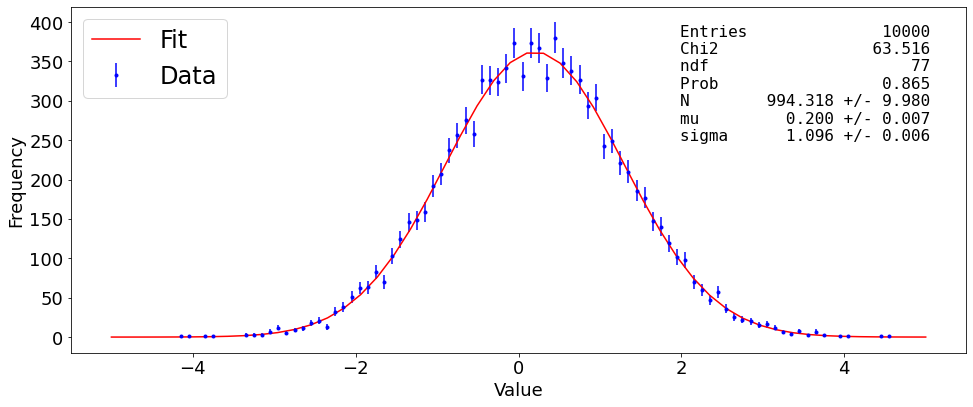

In [72]:
# Produce the points for drawing the fit:
xaxis = np.linspace(xmin, xmax)
yaxis = func_gaussian(xaxis, 
                   minuit_gaussian.values[0], 
                   minuit_gaussian.values[1], 
                   minuit_gaussian.values[2]
                  )

# Produce figure with histogram (with error bars) and fit overlayed:
fig, ax = plt.subplots(figsize=(14, 6))

ax.errorbar(x1, y1, sy1, fmt = '.', color = 'blue', label = 'Data')
ax.plot(xaxis, yaxis, '-', color = 'red', label = 'Fit')

ax.set(xlabel = "Value", 
       ylabel = "Frequency", 
       title = "")

ax.legend(loc = 'upper left', 
          fontsize=24);

# Produce a nice writeup of the fitting result in the figure:
d = {'Entries':  Npoints,
     'Chi2':     Chi2_gau,
     'ndf':      Ndof_gau,
     'Prob':     Prob_gau,
    }
for name in minuit_gaussian.parameters:
    d[name] = [minuit_gaussian.values[name], 
               minuit_gaussian.errors[name]]
    
text = nice_string_output(d, 
                          extra_spacing = 2, 
                          decimals = 3)
add_text_to_ax(0.68, 0.95, text, ax, fontsize=16)
fig.tight_layout()

## Linear chi2 fit

In [23]:
# Fitting function
def func_linear(x, alpha0, alpha1):
        return alpha0 + alpha1*x

In [55]:
# Parameters
alpha0 = 3.6
alpha1 = 0.3
sigma_y = 0.5

In [66]:
lin_Npoints = 50                        # Number of random points produced
lin_x = np.arange(lin_Npoints)               # Generate points in array
#exLin = np.zeros_like(lin_x)

lin_y = alpha0 + alpha1 * lin_x + r.normal(0, sigma_y, lin_Npoints)    # linear function + gaussian errors
error_lin_y = sigma_y * np.ones_like(lin_x)

In [67]:
# Fitting
chi2_linear = Chi2Regression(func_linear, lin_x, lin_y, error_lin_y)   # Fitting object
chi2_linear.errordef = Minuit.LEAST_SQUARES

# Give fitting function, its parameters their starting fitting values
minuit_linear = Minuit(chi2_linear, 
                         alpha0 = 2, 
                         alpha1 = 0.1)

minuit_linear.migrad()  # perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 46.26                      │         Nfcn = 32 (32 total)         │
│ EDM = 3.74e-22 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name   │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ alpha0 │   3.61    │   0.14    │            │            │         │         │       │
│ 1 │ alpha1 │   0.301   │   0.005   │            │            │         │         │       │
└───┴────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [68]:
chi2_linear, Ndof_linear, pval_linear = chi2_eval(minuit_linear, len(lin_x), 2)

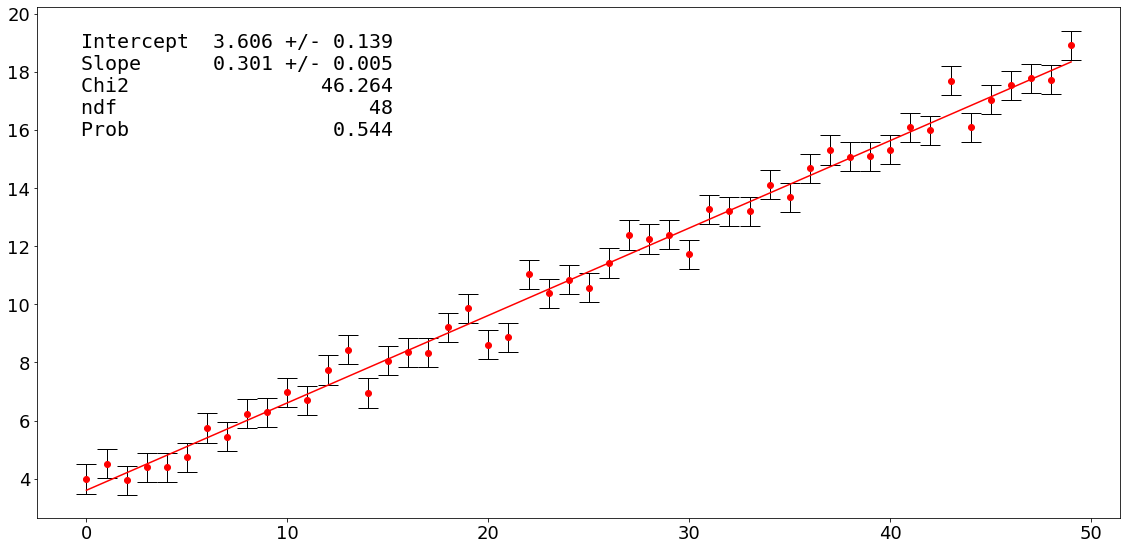

In [69]:
figLin, axLin = plt.subplots(figsize=(16, 8))

axLin.errorbar(lin_x, 
               lin_y, 
               error_lin_y, 
               fmt = 'ro', 
               ecolor = 'k', 
               elinewidth = 1, 
               capsize = 10, 
               capthick = 1)

axLin.plot(lin_x, 
           func_linear(lin_x, *minuit_linear.values[:]), 
           '-r')

d = {'Intercept':[minuit_linear.values['alpha0'], minuit_linear.errors['alpha0']],
     'Slope':    [minuit_linear.values['alpha1'], minuit_linear.errors['alpha1']],
     'Chi2':     chi2_linear,
     'ndf':      Ndof_linear,
     'Prob':     pval_linear,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.04, 0.95, text, axLin, fontsize=20)
figLin.tight_layout()

In [111]:
N_points = 10000  

# inverse integrated function added to itself 4 times
exp_inv = sum(-0.8*np.log(r.uniform(size = N_points)) for i in range(4))

# OG function given and summed
def exp_func(x):
    return sum(r.exponential(0.8, N_points) for i in range(4))

xmin_exp = 0
xmax_exp = 20

x_axis_exp = np.linspace(start = xmin_exp, 
                      stop = xmax_exp, 
                      num = 10000)
y_axis_exp = exp_func(x_axis_exp)

No handles with labels found to put in legend.


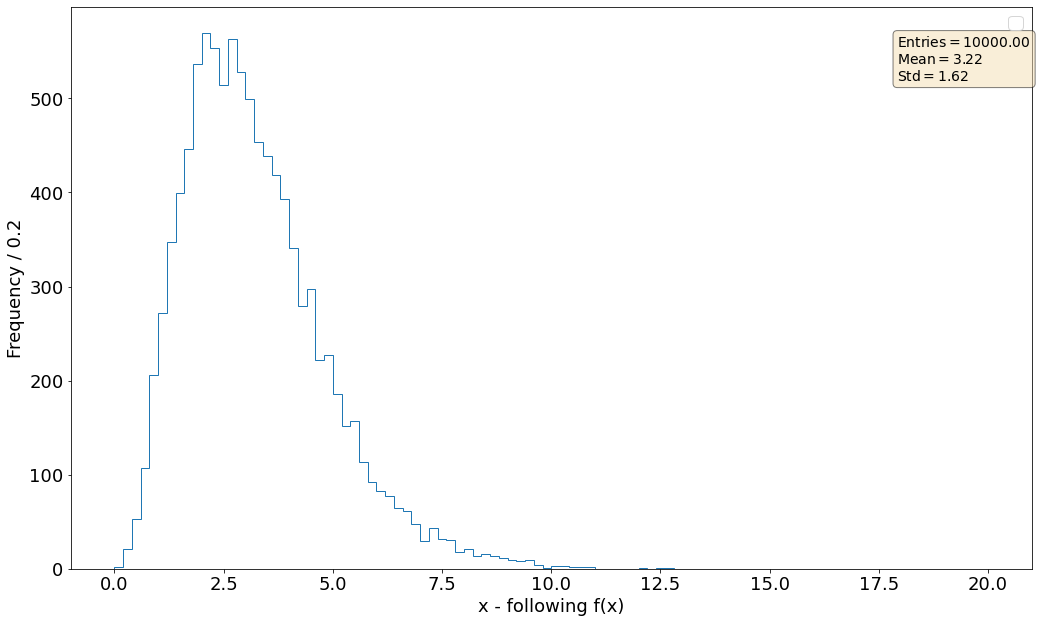

In [112]:
# Init plot object
fig, ax = plt.subplots(figsize=(15, 9))

# Plot generated data
ax.hist(exp_inv, 
        bins = Nbins, 
        range = (xmin_exp, xmax_exp), 
        histtype = 'step'
       )
# Plot labels
ax.set(xlabel = "x - following f(x)", 
       ylabel = "Frequency / 0.2", 
       xlim = (xmin_exp -1.0 , xmax_exp+1.0))

# Define figure text
textstr = '\n'.join((
    r'$\mathrm{Entries}=%.2f$' % (len(exp_inv), ),
    r'$\mathrm{Mean}=%.2f$' % (exp_inv.mean(), ),
    r'$\mathrm{Std}=%.2f$' % (exp_inv.std(ddof=1), )))
# Plot figure text
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
# place a text box in upper left in axes coords
ax.text(0.86, 0.95, textstr, transform=ax.transAxes, fontsize=14,
        verticalalignment='top', bbox=props)


ax.legend(loc = 'best')
fig.tight_layout()

In [113]:
x3, y3, sigma_y3 = hist_data(exp_inv, 100, 0, 20)

# Fitting
chi2_MC_Gauss = Chi2Regression(func_gaussian, x3, y3, sigma_y3)     # Fitting object
chi2_MC_Gauss.errordef = Minuit.LEAST_SQUARES

minuit_MC_Gauss = Minuit(chi2_MC_Gauss, 
                         N = N_points, 
                         mu = 3, 
                         sigma = 1.6)

minuit_MC_Gauss.migrad()       # Perform the actual fit

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1470                       │        Nfcn = 146 (146 total)        │
│ EDM = 1.18e-05 (Goal: 0.0002)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ N     │  1.715e3  │  0.019e3  │            │            │         │         │       │
│ 1 │ mu    │   3.141   │   0.020   │            │            │         │         │       │
│ 2 │ sigma │   1.224   │   0.012   │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘

In [114]:
chi2_MC_Gauss, Ndof_MC_Gauss, pval_MC_Gauss = chi2_eval(minuit_MC_Gauss, len(exp_inv), 3)

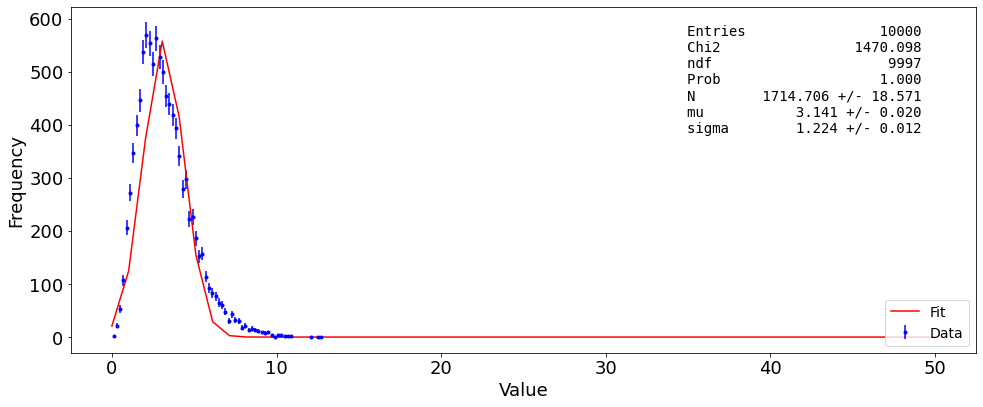

In [122]:
# Produce the points for drawing the fit:
xaxis_exp = np.linspace(0, 50)
yaxis_exp = func_gaussian(xaxis_exp, 
                   minuit_MC_Gauss.values[0], 
                   minuit_MC_Gauss.values[1], 
                   minuit_MC_Gauss.values[2]
                  )

# Produce figure with histogram (with error bars) and fit overlayed:
fig, ax = plt.subplots(figsize=(14, 6))

ax.errorbar(x3, y3, sigma_y3, fmt = '.', color = 'blue', label = 'Data')
ax.plot(xaxis_exp, yaxis_exp, '-', color = 'red', label = 'Fit')

ax.set(xlabel = "Value", 
       ylabel = "Frequency", 
       title = "")

ax.legend(loc = 'lower right', 
          fontsize=14);

# Produce a nice writeup of the fitting result in the figure:
d = {'Entries':  N_points,
     'Chi2':     chi2_MC_Gauss,
     'ndf':      Ndof_MC_Gauss,
     'Prob':     pval_MC_Gauss,
    }
for name in minuit_MC_Gauss.parameters:
    d[name] = [minuit_MC_Gauss.values[name], 
               minuit_MC_Gauss.errors[name]]
    
    
text = nice_string_output(d, 
                          extra_spacing = 2, 
                          decimals = 3)
add_text_to_ax(0.68, 0.95, text, ax, fontsize=14)
fig.tight_layout()

In [101]:
len(inv_u)

10000

In [102]:
len(x3)

58

In [103]:
len(x_all)

10000

In [104]:
len(x1)

80

In [106]:
len(y3)

58

In [107]:
len(xaxis)

50

In [108]:
len(yaxis)

10000